## 3 加载已训练模型进行预测

In [1]:
from __future__ import print_function
from six.moves import cPickle as pickle

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

% matplotlib inline

In [5]:
IMAGE_SIZE = 32
NUM_DIGITS = 5
NUM_LABELS = 11 # 0-9 + 10==doesn't exist
NUM_CHANNELS = 1 # grayscale

In [6]:
BATCH_SIZE = 64
PATCH_SIZE = 5
DEPTH_1 = 24
DEPTH_2 = 48
DEPTH_3 = 80
NUM_HIDDEN = 256
SEED = 42

In [7]:
def createWeight(shape, name):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1), name=name)

In [8]:
def createBiase(shape, name):
    return tf.Variable(tf.zeros(shape), name=name)

In [9]:
graph = tf.Graph()
with graph.as_default():
    # Input data
    tf_train_dataset = tf.placeholder(tf.float32, shape=(None, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))
    tf_train_labels = tf.placeholder(tf.int64, shape=(None, NUM_DIGITS))
    
    conv1_W = createWeight([PATCH_SIZE, PATCH_SIZE, NUM_CHANNELS, DEPTH_1], 'conv1_weights')
    conv1_B = createBiase([DEPTH_1], 'conv1_biases')
    conv2_W = createWeight([PATCH_SIZE, PATCH_SIZE, DEPTH_1, DEPTH_2], 'conv2_weights')
    conv2_B = createBiase([DEPTH_2], 'conv2_biases')
    conv3_W = createWeight([PATCH_SIZE, PATCH_SIZE, DEPTH_2, DEPTH_3], 'conv3_weights')
    conv3_B = createBiase([DEPTH_3], 'conv3_biases')
    fc1_W = createWeight([IMAGE_SIZE//8 * IMAGE_SIZE//8 * DEPTH_3, NUM_HIDDEN], 'fc1_weights')
    fc1_B = createBiase([NUM_HIDDEN], 'fc1_biases')
    
    fc_d1_W = createWeight([NUM_HIDDEN, NUM_LABELS], 'fc_digit1_weights')
    fc_d1_B = createBiase([NUM_LABELS], 'fc_digit1_biases')
    fc_d2_W = createWeight([NUM_HIDDEN, NUM_LABELS], 'fc_digit2_weights')
    fc_d2_B = createBiase([NUM_LABELS], 'fc_digit2_biases')
    fc_d3_W = createWeight([NUM_HIDDEN, NUM_LABELS], 'fc_digit3_weights')
    fc_d3_B = createBiase([NUM_LABELS], 'fc_digit3_biases')
    fc_d4_W = createWeight([NUM_HIDDEN, NUM_LABELS], 'fc_digit4_weights')
    fc_d4_B = createBiase([NUM_LABELS], 'fc_digit4_biases')
    fc_d5_W = createWeight([NUM_HIDDEN, NUM_LABELS], 'fc_digit5_weights')
    fc_d5_B = createBiase([NUM_LABELS], 'fc_digit5_biases')

    
    saver = tf.train.Saver(tf.trainable_variables()) # defaults to saving all variables
    
    def model(data):
        conv = tf.nn.conv2d(data, conv1_W, strides=[1, 1, 1, 1], padding='SAME')
        relu = tf.nn.relu(tf.nn.bias_add(conv, conv1_B))
        relu = tf.nn.local_response_normalization(relu)
        pool = tf.nn.max_pool(relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        conv = tf.nn.conv2d(pool, conv2_W, strides=[1, 1, 1, 1], padding='SAME')
        relu = tf.nn.relu(tf.nn.bias_add(conv, conv2_B))
        relu = tf.nn.local_response_normalization(relu)
        pool = tf.nn.max_pool(relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        conv = tf.nn.conv2d(pool, conv3_W, strides=[1, 1, 1, 1], padding='SAME')
        relu = tf.nn.relu(tf.nn.bias_add(conv, conv3_B))
        relu = tf.nn.local_response_normalization(relu)
        pool = tf.nn.max_pool(relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        shape = pool.get_shape().as_list()
        reshape = tf.reshape(pool, [-1, shape[1]*shape[2]*shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, fc1_W) + fc1_B)
            
        logit_d1 = tf.matmul(hidden, fc_d1_W) + fc_d1_B
        logit_d2 = tf.matmul(hidden, fc_d2_W) + fc_d2_B
        logit_d3 = tf.matmul(hidden, fc_d3_W) + fc_d3_B
        logit_d4 = tf.matmul(hidden, fc_d4_W) + fc_d4_B
        logit_d5 = tf.matmul(hidden, fc_d5_W) + fc_d5_B
        
        return logit_d1, logit_d2, logit_d3, logit_d4, logit_d5
    
    def predict(logits):
        return tf.transpose(tf.pack([tf.argmax(logits[0], 1), tf.argmax(logits[1], 1), tf.argmax(logits[2], 1), \
                        tf.argmax(logits[3], 1), tf.argmax(logits[4], 1)]))
        
    logits = model(tf_train_dataset)
    
    train_prediction = predict(logits)

In [1]:
def gcn(dataset):
    """Global contrast normalization"""
    mean = dataset.mean(axis=(1,2))
    std = dataset.std(axis=(1,2))
    return (dataset - mean[:, None, None]) / std[:, None, None]

### 计算测试集的分类准确率

In [11]:
image_size_40px = ''
#image_size_40px = '_40'

In [12]:
def accuracy(predictions, labels):
    return np.mean(np.all(predictions == labels, axis=1))

In [13]:
pickle_file = 'svhn_multi_test%s.pickle' % image_size_40px

with open(pickle_file, 'rb') as f:
    dataset = pickle.load(f)
    test_dataset = dataset['dataset']
    test_labels = dataset['labels'][:, 1:6]
    
print('Dataset shape: ', test_dataset.shape)
print('Labels shape: ', test_labels.shape)

Dataset shape:  (13068, 32, 32)
Labels shape:  (13068, 5)


In [14]:
images = test_dataset
test_dataset = images.reshape((-1, IMAGE_SIZE, IMAGE_SIZE, 1))
test_dataset.shape

(13068, 32, 32, 1)

- 一次性输入全部测试集数据，Python会因为GPU存储不够而崩溃。
- 因此，计算测试集分类准确率的时候也需要分批计算，同时将预测的结果保存到array中。
- 下面借助Python生成器对数据进行分批。

In [15]:
test_batch_size = 100

In [16]:
def next_batch(data, labels, batch_size):
    # 借助Python生成器对数据进行分批。
    for i in range((data.shape[0] + batch_size - 1) // batch_size):
        yield data[i*batch_size:(i+1)*batch_size], labels[i*batch_size:(i+1)*batch_size]

In [17]:
prediction = np.zeros(test_labels.shape, dtype=np.int32)

In [18]:
batches = next_batch(test_dataset, test_labels, test_batch_size)

In [19]:
with tf.Session(graph=graph) as session:
    saver.restore(session, 'multi22.ckpt')
    for i, batch in enumerate(batches):
        prediction[i*test_batch_size:(i+1)*test_batch_size] = \
            session.run(train_prediction, feed_dict={tf_train_dataset: batch[0], tf_train_labels: batch[1]})
        

In [20]:
accuracy(prediction, test_labels)

0.87404346495255592

### 展示预测错误的图片

In [18]:
prediction == test_labels

array([[ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       ..., 
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True]], dtype=bool)

In [19]:
predict_correct = np.all(prediction == test_labels, axis=1)

In [20]:
predict_wrong = np.invert(predict_correct)

In [21]:
def label_to_str(label):
    s = ''
    for d in label:
        if d < 10:
            s += str(d)
        else:
            s += '*'
    return s

In [22]:
def plot_images(images, labels):
    fig, axes = plt.subplots(nrows=5, ncols=7, figsize=(6,5))
    #fig.subplots_adjust(hspace=0.3, wspace=0.1)
    for i, ax in enumerate(axes.flatten()):
        ax.axis('off')
        ax.imshow(images[i], cmap=plt.cm.gray, interpolation='none')
        ax.set_title( label_to_str(labels[i]) )

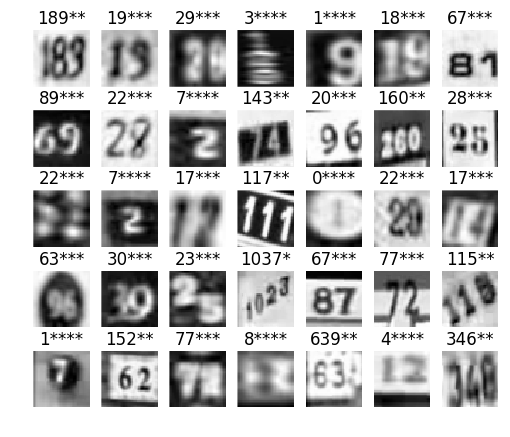

In [23]:
plot_images(test_dataset[predict_wrong].reshape((-1, IMAGE_SIZE, IMAGE_SIZE)), prediction[predict_wrong])

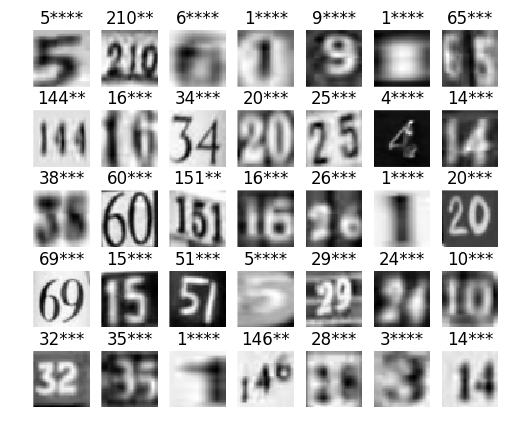

In [24]:
plot_images(test_dataset[predict_correct].reshape((-1, IMAGE_SIZE, IMAGE_SIZE)), prediction[predict_correct])

In [25]:
test_dataset[predict_wrong].reshape((-1, IMAGE_SIZE, IMAGE_SIZE)).shape

(1918, 40, 40)

### 使用模型预测单张图片标签

In [ ]:
import random

In [ ]:
index = random.randint(0, test_dataset.shape[0])

In [ ]:
index

In [ ]:
image = test_dataset[index]

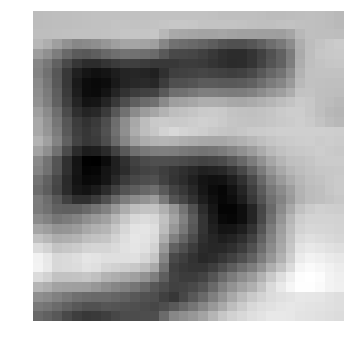

In [9]:
plt.axis('off')
plt.imshow(test_dataset[index].reshape((IMAGE_SIZE, IMAGE_SIZE)), cmap=plt.cm.gray, interpolation='nearest')

In [12]:
with tf.Session(graph=graph) as session:
    saver.restore(session, 'multi.ckpt')
    #test_prediction = train_prediction.eval(feed_dict={tf_train_dataset: test_dataset})
    prediction = train_prediction.eval(feed_dict={tf_train_dataset: test_dataset})

In [13]:
prediction

77.770142

In [ ]:
test_labels[index]